## Import package

In [ ]:
import sys
sys.path.append('/ET_OptME/script')
# import ETGEMs_function_protain as etgf
from ETGEMs_function_protain import *
from ET_optme import *
import pandas as pd
import cobra
import gurobipy
import json
import multiprocessing
import os
from multiprocessing import Pool
from tqdm import tqdm 
from sympy import subsets
import pandas as pd
import matplotlib.pyplot as plt
import re

## setting path for models and data, example: using C.glutamicum to produce L_Isoleucine

In [ ]:
# data 
model_file="./data/lys.json" # c.glutamicum model, irreversible and reactions with isoezyme splited
reaction_kcat_MW_file='./data/reaction_change_by_enzuse_PDH_n.csv'
# results
path_results = './ET_OptME/result'
savepath = './result/picture'
dictionarymodel_path='./result/dictionarymodel_iCW.json' # dictionary model saving path
wild_reaction_flux_path='./result/reaction centered/wild-enzyme-reaction_e0_ile10.27.json'
over_reaction_flux_path='./result/reaction centered/over-enzyme-reaction_e0_ile10.27.json'
wild_enzyme_concentration_path = './result/ET_Optme/result/ile/wild-enzyme.json'
over_enzyme_concentration_path = './result/ET_Optme/result/ile/over-enzyme.json'
# case study
model0_file = './task/iCW773_uniprot_modification_del.json'
reaction_g0_file=os.path.join('./task/iCW773_uniprot_modification_del_reaction_g0.csv')
metabolites_lnC_file = os.path.join('./task/metabolites_lnC_cg1.txt')

## setting task, prepare task.json

In [ ]:
# model、substrate、product、oxygence
# mode: SET
inputdic = {"model":'lys.json',
"substrate":"EX_glc_e_reverse",
"biomass": "CG_biomass_cgl_ATCC13032",
 "product": "EX_ile_L_e",
"taskname": "optforce",
"mode":"SET",
"oxygenstate":"aerobic"}
# save task.json
with open('./data/task.json', 'w') as json_file:
    json.dump(inputdic, json_file, indent=4)
path_strain = 'iCW'

## invoke ET-OptME and run the task 

## 1.enzyme-thermo Model Construction

In [14]:
# read model
model = cobra.io.load_json_model(model_file)

# Store model data into Get_Concretemodel_Need_Data
Concretemodel_Need_Data = Get_Concretemodel_Need_Data(model_file)

#model0 = cobra.io.load_json_model(model0_file)

# Save the protein-centered model as a dictionary
dictionary_model = json_load(dictionarymodel_path)
dictionary_model.keys()

rname3 = []

# Store the protein-centered dictionary into Get_Concretemodel_Need_Data
get_dictionarymodel_data2(dictionary_model, Concretemodel_Need_Data, rname3)

# Store thermodynamic data into Get_Concretemodel_Need_Data
Get_Concretemodel_Need_Data_g0(Concretemodel_Need_Data, reaction_g0_file, metabolites_lnC_file, reaction_kcat_MW_file)

Concretemodel_Need_Data['reaction_g0']['g0'] = Concretemodel_Need_Data['reaction_g0']['g0'].replace(0, np.nan)
Concretemodel_Need_Data['reaction_g0'].dropna(subset=['g0'], inplace=True)

Concretemodel_Need_Data['reaction_g0'].at['AIRC3_reverse', 'g0'] = 0
Concretemodel_Need_Data['reaction_g0'].at['ATPS4rpp_reverse_num2', 'g0'] = 0

Inc = Concretemodel_Need_Data['metabolites_lnC']

for i in Concretemodel_Need_Data['metabolite_list']:
    if i not in Inc.index:
        Inc.loc[i, 'lnClb'] = -14.508658
        Inc.loc[i, 'lnCub'] = -3.912023

Concretemodel_Need_Data['metabolites_lnC'] = Inc

# Modify the oxygen conditions of the model
if inputdic['oxygenstate'] == 'aerobic':
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 1000
if inputdic['oxygenstate'] == 'micro_aerobic': 
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 2 
if inputdic['oxygenstate'] == 'anaerobic': 
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 0



## 2.Algorithm :  ET-OptForceM

In [15]:
# Calculate the maximum growth rate #打印出数值的解释和单位
B_value1,v0_biomass,bio,totalE,objvalue2 = calculate_biomass(Concretemodel_Need_Data,inputdic,model,'iCW')

maximum growth rate value is: 0.42872386022140163(mmol/gDW/h)
The maximum thermodynamic driving force value is : 0.42872386022140163
minimizing the total enzyme concentration  is: 0.12121613628992045((mmol/gDW)


In [ ]:
# Calculate the enzyme concentration range under maximum growth conditions
enzyme_list = list(Concretemodel_Need_Data['mw_dict'].keys()) 
obj_names = enzyme_list
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# Use multiprocessing to calculate the wild range for each enzyme
results = pool.starmap(calculate_wildrange, [(Concretemodel_Need_Data, obj_name, inputdic, objvalue2, v0_biomass, totalE, path_strain, B_value1) for obj_name in obj_names])

pool.close()
pool.join()

# Combine the results into a final dictionary
final_results = {}
for result in results:
    final_results.update(result)

# Save the results as a JSON file
wild_file_path = os.path.join(wild_enzyme_concentration_path)
with open(wild_file_path, 'w') as json_file:
    json.dump(final_results, json_file)



Read LP format model from file /tmp/tmp3efno63j.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp0wog9lnh.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpu_y5ll_f.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpiulqu9iu.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpqxfohq7s.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpnm_m3gz2.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp1kpd5crq.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp8955a66i.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmps

In [ ]:
# The enzymes that catalyze each reaction in the model
enzyme_list = list(Concretemodel_Need_Data['mw_dict'].keys()) 
obj_names = enzyme_list
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

results = pool.starmap(calculate_over, [(Concretemodel_Need_Data,obj_name,inputdic,objvalue2,v0_biomass,v1_product_max,totalE2,path_strain,B_value2) for obj_name in obj_names])
pool.close()
pool.join()


final_results = {}
for result in results:
    final_results.update(result)
over_file_path = os.path.join(over_enzyme_concentration_path)
with open(over_file_path, 'w') as json_file:
    json.dump(final_results, json_file)

Read LP format model from file /tmp/tmpfqjlbr9r.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpzj2siohw.lp
Reading time = 0.03 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpyjpbivh4.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp7ngwg8ul.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpzjg6xrdd.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpyo5x8we7.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpw46v3l0m.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpbhvb8rdq.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpo

## Analyze the result and generate table and figure(range compare, flux vs prouct) 

In [ ]:
#Read results file
enzyme_results_data,enzyme_overresults2_data = read_file(path_results)

In [ ]:
# Filter the targets that need modification
ko_data,up_data,down_data = compare_results(enzyme_results_data, enzyme_overresults2_data,inputdic)

In [ ]:
# get reaction equation
equation_dict = gene_reaction_map1(reaction_list,model)

In [ ]:
# Enzyme concentrations and flux distribution under the wild-type condition
E_refdict, mw_dict, reaction_dict_bio, kcat_dict = ref_e_con(inputdic, Concretemodel_Need_Data, totalE, path_strain, objvalue2)


0.4072876672083201


In [ ]:
# Retrieve gene, equation, and reaction mappings
new_gene_reaction_mapping_bio, gene_reaction_mapping, gene_kcat_mapping = gene_reaction_map(enzyme_list, reaction_dict_bio, kcat_dict, Concretemodel_Need_Data, model)


## get reaction flux

In [ ]:
# Retrieve the reaction flux distribution under maximum production conditions
reaction_dict, kcat_dict, EcoECM_FBA_protainmodel_pro_max = reaction_flux(inputdic, Concretemodel_Need_Data, totalE2, path_strain, totalE, objvalue2, v0_biomass)

2.740861572132984


In [ ]:
# Retrieve the enzyme concentrations and corresponding reaction flux distributions for the overexpressed state
new_gene_reaction_mapping, gene_reaction_mapping, gene_kcat_mapping = gene_reaction_map(enzyme_list, reaction_dict, kcat_dict, Concretemodel_Need_Data, model)

In [ ]:
# Retrieve the enzyme usage proportions for each enzyme in the model
normalized_E_dict, E_dict, e_dict = enzyme_usage_over(EcoECM_FBA_protainmodel_pro_max, Concretemodel_Need_Data)


sum: 0.07605156126806689


In [ ]:
# Calculate the adjustment level for each modification strategy
Fold_change = fold_change(E_dict, E_refdict)

In [ ]:
# List of all reactions in the model
reaction_list = []
for rea in model.reactions:
    reaction_list.append(rea.id)

In [ ]:
# Retrieve the reaction equations
equation_dict = gene_reaction_map1(reaction_list, model)

In [ ]:
# Generate the result table (modification strategies, equations, adjustment levels, enzyme proportions, etc.)
meged_df = must_df(inputdic, equation_dict, new_gene_reaction_mapping_bio, new_gene_reaction_mapping, E_refdict, E_dict, Fold_change, normalized_E_dict, e_dict, gene_kcat_mapping, enzyme_results_data, enzyme_overresults2_data, ko_data, up_data, down_data, Concretemodel_Need_Data)


In [ ]:
# Overflow reactions in the model for wild and overexpressed states, along with biomass and product B value
bio_df, pro_df, KeyInfo = basic(bio, pro, B_value1, v0_biomass, B_value2, v1_product_max, totalE, totalE2, inputdic)


In [ ]:
# Identify bottleneck reactions under thermodynamic constraints
bottleneck_reactions_list, Df = bottleneck_reactions(EcoECM_FBA_protainmodel_B2, model)


In [ ]:
# Generate the result table
output(KeyInfo,path_results,bio_df,pro_df,meged_df,inputdic,Df)

## Get gene name

In [ ]:
# read xlsx file
optforce_lys = pd.read_excel('./result/ET_Optme/result/ile/results_SET.xlsx', sheet_name='MUST')

In [ ]:
# Filter reactions with manipulations labeled as UP
optforce_lys_up = optforce_lys[optforce_lys['manipulations'] == 'Up']
optforce_lys_up


,Unnamed: 0.1,Unnamed: 0,gene,enzyme_wild,enzyme_over,reaction_bio,reaction_pro,ref_e_con(g/gDW),over_e_con(g/gDW),Fold_change,enzyme_usage_over,manipulations,e1(mmol/gDW),kcat(1/h),mw(g/mg)
0,0,0,Cgl1273,"['1.742e-03', '1.864e-03']","['1.452e-02', '1.460e-02']",KARA1_reverse (0.27937066159703733): alac__S_c...,KARA2 (3.002127237423596): 2ahbut_c + h_c + na...,0.001742,0.014520,8.336,18.6500,Up,0.000402,"[('KARA2', 7549.714285714285)]",36.16
4,4,4,Cgl1268,"['8.772e-04', '9.987e-04']","['7.312e-03', '7.385e-03']",DHAD1 (0.27937066159703733): 23dhmb_c --> 3mob...,DHAD2 (3.002127237423596): 23dhmp_c --> 3mop_c...,0.000877,0.007312,8.336,9.3930,Up,0.000057,"[('DHAD2', 53623.661538461536)]",129.30
5,5,5,Cgl1183 and Cgl1184,"['3.843e-04', '5.055e-04']","['5.620e-03', '5.692e-03']",HSK (0.20618713881950834): atp_c + hom__L_c --...,HSK (3.0149565070421405): atp_c + hom__L_c -->...,0.000384,0.005620,14.620,7.2190,Up,0.000071,"[('HSK', 42414.54545454545)]",79.06
6,6,6,Cgl0251,"['6.966e-04', '8.767e-04']","['5.600e-03', '5.678e-03']",ASPK (0.4082730598916492): asp__L_c + atp_c --...,ASPK (3.029349137884897): asp__L_c + atp_c -->...,0.000755,0.005600,7.420,7.1930,Up,0.000044,"[('ASPK', 68478.9882352941)]",126.60
7,7,7,Cgl1578,"['1.239e-03', '1.460e-03']","['3.649e-03', '3.756e-03']",PGL (2.814558313525697): 6pgl_c + h2o_c --> 6p...,PGL (7.7479456366500665): 6pgl_c + h2o_c --> 6...,0.001338,0.003684,2.753,4.7320,Up,0.000150,"[('PGL', 51480.0)]",24.48
8,8,8,Cgl2204,"['1.486e-04', '3.001e-04']","['1.859e-03', '1.940e-03']",LEUTAi (0.15698924074667858): 4mop_c + glu__L_...,ILETA (3.002127237423596): 3mop_c + glu__L_c -...,0.000149,0.001859,12.510,2.3880,Up,0.000045,"[('ILETA', 67698.0)]",41.69
9,9,9,Cgl0689,"['6.732e-04', '8.131e-04']","['1.772e-03', '1.858e-03']",PYRC (1.2126965609210643): atp_c + hco3_c + py...,PYRC (3.114025295888694): atp_c + hco3_c + pyr...,0.000691,0.001775,2.568,2.2800,Up,0.000014,"[('PYRC', 216000.0)]",123.10
11,11,11,Cgl1183,"['1.078e-04', '2.416e-04']","['1.187e-03', '1.265e-03']",HSDy_reverse (0.3054201339389815): aspsa_c + h...,HSDy_reverse (3.018522514100252): aspsa_c + h_...,0.000120,0.001187,9.883,1.5250,Up,0.000026,"[('HSDy_reverse', 118074.81599999998)]",46.44
12,12,12,Cgl1271 and Cgl1272,"['1.343e-04', '2.557e-04']","['1.119e-03', '1.201e-03']",ACLS (0.27937066159703733): h_c + 2.0 pyr_c --...,ACHBS (3.002127237423596): 2obut_c + h_c + pyr...,0.000134,0.001119,8.336,1.4380,Up,0.000013,"[('ACHBS', 231848.1)]",85.59
13,13,13,Cgl1452,"['2.341e-04', '3.742e-04']","['6.897e-04', '7.530e-04']",GND (2.814558313525697): 6pgc_c + nadp_c --> c...,GND (7.7479456366500665): 6pgc_c + nadp_c --> ...,0.000253,0.000696,2.753,0.8945,Up,0.000007,"[('GND', 1170000.0)]",105.20


In [ ]:
# Filter reactions with manipulations labeled as down
optforce_lys_down = optforce_lys[optforce_lys['manipulations'] == 'down']
optforce_lys_down


,Unnamed: 0.1,Unnamed: 0,gene,enzyme_wild,enzyme_over,reaction_bio,reaction_pro,ref_e_con(g/gDW),over_e_con(g/gDW),Fold_change,enzyme_usage_over,manipulations,e1(mmol/gDW),kcat(1/h),mw(g/mg)
1,1,1,Cgl0937,"['1.229e-02', '1.249e-02']","['1.105e-02', '1.122e-02']",GAPD_num1 (7.319741903436487): g3p_c + nad_c +...,GAPD_num1 (6.560790335068852): g3p_c + nad_c +...,0.012370,0.011090,0.89630,14.240000,down,2.825000e-04,"[('GAPD_num1', 23220.0)]",39.23
2,2,2,Cgl2192 and Cgl2194 and Cgl2195 and Cgl2523,"['1.930e-02', '1.950e-02']","['7.743e-03', '8.002e-03']",CYTBO3_4pp (16.71147797835769): 4.0 h_c + 0.5 ...,CYTBO3_4pp (6.838024236057076): 4.0 h_c + 0.5 ...,0.019370,0.007924,0.40920,10.180000,down,5.552000e-05,"[('CYTBO3_4pp', 123153.39015652175)]",142.70
3,3,3,Cgl1206 and Cgl1207 and Cgl1208 and Cgl1209 an...,"['3.311e-02', '3.340e-02']","['7.542e-03', '8.081e-03']",ATPS4rpp (27.309877521249472): adp_c + 4.0 h_e...,ATPS4rpp (6.281043277530893): adp_c + 4.0 h_e ...,0.033280,0.007655,0.23000,9.833000,down,1.625000e-05,"[('ATPS4rpp', 386596.0)]",471.20
14,14,14,Cgl1623,"['5.827e-03', '5.948e-03']","['6.133e-04', '6.912e-04']",CHORS (0.10431924197502718): 3psme_c --> chor_...,NaN,0.005827,0.000613,0.10530,0.787800,down,3.506000e-06,NaN,174.90
16,16,16,Cgl1250,"['8.003e-04', '9.334e-04']","['4.901e-04', '5.701e-04']",PFK (3.3021831765338603): atp_c + f6p_c --> ad...,PFK (2.0019443612588184): atp_c + f6p_c --> ad...,0.000812,0.000492,0.60620,0.632500,down,6.572000e-06,"[('PFK', 304632.0)]",74.93
17,17,17,Cgl2491,"['4.132e-03', '4.290e-03']","['4.159e-04', '5.121e-04']",3OAS100_num1 (0.18832808148335356): h_c + malA...,NaN,0.004168,0.000439,0.10530,0.563600,down,2.974000e-05,NaN,14.75
18,18,18,Cgl1609 and Cgl1610,"['3.809e-03', '3.930e-03']","['4.009e-04', '4.788e-04']",CBPS (0.14196229628244195): 2.0 atp_c + gln__L...,NaN,0.003809,0.000401,0.10530,0.515000,down,1.236000e-06,NaN,324.30
22,22,22,Cgl2770,"['5.215e-04', '6.512e-04']","['3.193e-04', '3.988e-04']",FBA (3.3021831765338603): fdp_c --> dhap_c + g...,FBA (2.0019443612588184): fdp_c --> dhap_c + g...,0.000529,0.000321,0.60620,0.412100,down,8.622000e-06,"[('FBA', 232200.0)]",37.21
23,23,23,Cgl0366 and Cgl2207 and Cgl2248,"['4.986e-03', '5.164e-03']","['0.000e+00', '3.833e-04']",PDH (4.392836689942083): coa_c + nad_c + pyr_c...,PDH (0.2661898540536591): coa_c + nad_c + pyr_...,0.005043,0.000306,0.06060,0.392600,down,1.521000e-07,"[('PDH', 1749600.0)]",2009.00
24,24,24,Cgl0828,"['2.026e-03', '2.188e-03']","['1.921e-04', '2.954e-04']",PSERT (0.46260110738617705): 3php_c + glu__L_c...,NaN,0.002067,0.000218,0.10530,0.279400,down,5.432000e-06,NaN,40.05


In [ ]:
# Filter reactions with manipulations labeled as Up
optforce_lys_up = optforce_lys[optforce_lys['manipulations'] == 'Up']
optforce_lys_up

# Find enzyme names through GPR relationships
import pandas as pd

# Read the TSV file
tsv_data = pd.read_csv('./date/gene_overview_init.tsv', delimiter='\t')

all = {}
# Process each value
for genes in optforce_lys_up['gene']:
    gene_ids = genes.split(' and ') if isinstance(genes, str) else []
    gene_names = []
    for gene in gene_ids:
        matches = tsv_data[tsv_data['Cgl_ID'] == gene]
        if not matches.empty:
            gene_name = str(matches.iloc[0]['Gene_Name'])
            gene_names.append(gene_name)
        else:
            gene_names.append('None')  # If no corresponding Gene_Name is found, set it to the string 'None' or another appropriate default value
    combined_names = ', '.join(gene_names)
    all[genes] = combined_names

optforce_lys_up['enzyme'] = optforce_lys_up['gene'].map(all)


/tmp/ipykernel_44522/3810592716.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optforce_lys_up['enzyme'] = optforce_lys_up['gene'].map(all)


In [ ]:
# Filter reactions with manipulations labeled as down
optforce_lys_down = optforce_lys[optforce_lys['manipulations'] == 'down']
optforce_lys_down

# Find enzyme names through GPR relationships
import pandas as pd

# Read the TSV file
tsv_data = pd.read_csv('./date/gene_overview_init.tsv', delimiter='\t')

all = {}
# Process each value
for genes in optforce_lys_down['gene']:  # Corrected to use optforce_lys_down
    gene_ids = genes.split(' and ') if isinstance(genes, str) else []
    gene_names = []
    for gene in gene_ids:
        matches = tsv_data[tsv_data['Cgl_ID'] == gene]
        if not matches.empty:
            gene_name = str(matches.iloc[0]['Gene_Name'])
            gene_names.append(gene_name)
        else:
            gene_names.append('None')  # If no corresponding Gene_Name is found, set it to the string 'None' or another appropriate default value
    combined_names = ', '.join(gene_names)
    all[genes] = combined_names

optforce_lys_down['enzyme'] = optforce_lys_down['gene'].map(all)


/tmp/ipykernel_44522/1429311535.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optforce_lys_down['enzyme'] = optforce_lys_down['gene'].map(all)


In [ ]:
filename=os.path.join('./ET_OptME/result/results_ETM.xlsx')
with pd.ExcelWriter(filename) as writer:
    optforce_lys.to_excel(writer,sheet_name='MUST',index=True)
    optforce_lys_down.to_excel(writer,sheet_name='down',index=True)
    optforce_lys_up.to_excel(writer,sheet_name='up',index=True)

## Analysis ET-OptForce results

In [ ]:
df = pd.read_excel('.ET_OptME/result/ET_Optme/result/lys/results_S.xlsx')
df = df.drop('Unnamed: 0.1', axis=1)
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
pyrc = df[df['reaction']=='PYRC']
ICDHyr = df[df['reaction']=='ICDHyr']
GND = df[df['reaction']=='GND']

In [ ]:
pyrc = pyrc.iloc[:, :4]
ICDHyr = ICDHyr.iloc[:, :4]
GND = GND.iloc[:, :4]
S_result_pyrc = {}
S_result_icd = {}
S_result_gnd = {}
for index, row in pyrc.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_pyrc = {"id":"OptForce","reaction": 'PYRC:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_pyrc[reaction_name] = s_temp_dict_pyrc
for index, row in ICDHyr.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_icd = {"id":"OptForce","reaction":'ICDHyr:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_icd[reaction_name] = s_temp_dict_icd

for index, row in GND.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_gnd = {"id":"OptForce","reaction": 'GND:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_gnd[reaction_name] = s_temp_dict_gnd

In [ ]:
tdf = pd.read_excel('./ET_OptME/result/ET_Optme/result/lys/results_T.xlsx',sheet_name='MUST')

In [ ]:
tdf = tdf.drop('Unnamed: 0', axis=1)
tdf = tdf.drop('Unnamed: 0.1', axis=1)
tdf_pyrc= tdf[tdf['reaction']=='PYRC']
tdf_ICDHyr = tdf[tdf['reaction']=='ICDHyr']
tdf_GND = tdf[tdf['reaction']=='GND']

In [ ]:


tdf_pyrc = tdf_pyrc.iloc[:, :4]
tdf_ICDHyr = tdf_ICDHyr.iloc[:, :4]
tdf_GND = tdf_GND.iloc[:, :4]
T_result_pyrc = {}
T_result_icd = {}
T_result_gnd = {}
for index, row in tdf_pyrc.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_pyrc = {"id":"T_OptForce","reaction":'PYRC:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_pyrc[reaction_name] = T_result_dict_pyrc
for index, row in tdf_ICDHyr.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_icd = {"id":"T_OptForce","reaction":'ICDHyr:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_icd[reaction_name] = T_result_dict_icd

for index, row in tdf_GND.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_gnd = {"id":"T_OptForce","reaction":'GND:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_gnd[reaction_name] = T_result_dict_gnd

In [ ]:
edf = pd.read_excel('./ET_OptME/result/ET_Optme/result/lys/results_ET.xlsx',sheet_name='MUST')

In [ ]:
edf = edf.drop('Unnamed: 0', axis=1) 
edf = edf.drop('Unnamed: 0.1', axis=1)
edf_pyrc= edf[edf['gene']=='Cgl0689']
edf_icd= edf[edf['gene']=='Cgl0664']
edf_gnd= edf[edf['gene']=='Cgl1452']

In [ ]:
ET_result_dict_pyrc = {}
ET_result_dict_icd = {}
ET_result_dict_gnd = {}
edf_pyrc = edf_pyrc.iloc[:, :4]
edf_icd = edf_icd.iloc[:, :4]
edf_gnd = edf_gnd.iloc[:, :4]

for index, row in edf_pyrc.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_pyrc = {"id":"ET_OptForce","reaction":'Cgl0689:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    # 原始reaction字符串
    reaction = et_temp_dict_pyrc['reaction']

    # 使用split和join方法去除括号中的内容
    # 先按 '(' 分割，然后取分割后的第一部分，再按 ':' 分割并重新拼接
    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()
    # 更新reaction字符串
    et_temp_dict_pyrc['reaction'] = reaction_cleaned
    ET_result_dict_pyrc[reaction_name] = et_temp_dict_pyrc
for index, row in edf_icd.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_icd = {"id":"ET_OptForce","reaction":'Cgl0664:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = et_temp_dict_icd['reaction']
    # 使用split和join方法去除括号中的内容
    # 先按 '(' 分割，然后取分割后的第一部分，再按 ':' 分割并重新拼接
    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()
    # 更新reaction字符串
    et_temp_dict_icd['reaction'] = reaction_cleaned    
    ET_result_dict_icd[reaction_name] = et_temp_dict_icd

for index, row in edf_gnd.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_gnd = {"id":"ET_OptForce","reaction":'Cgl1452:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = et_temp_dict_gnd['reaction']
    # 使用split和join方法去除括号中的内容
    # 先按 '(' 分割，然后取分割后的第一部分，再按 ':' 分割并重新拼接
    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()
    # 更新reaction字符串
    et_temp_dict_gnd['reaction'] = reaction_cleaned    
    ET_result_dict_gnd[reaction_name] = et_temp_dict_gnd

## Case Study of Algorithm Advantages

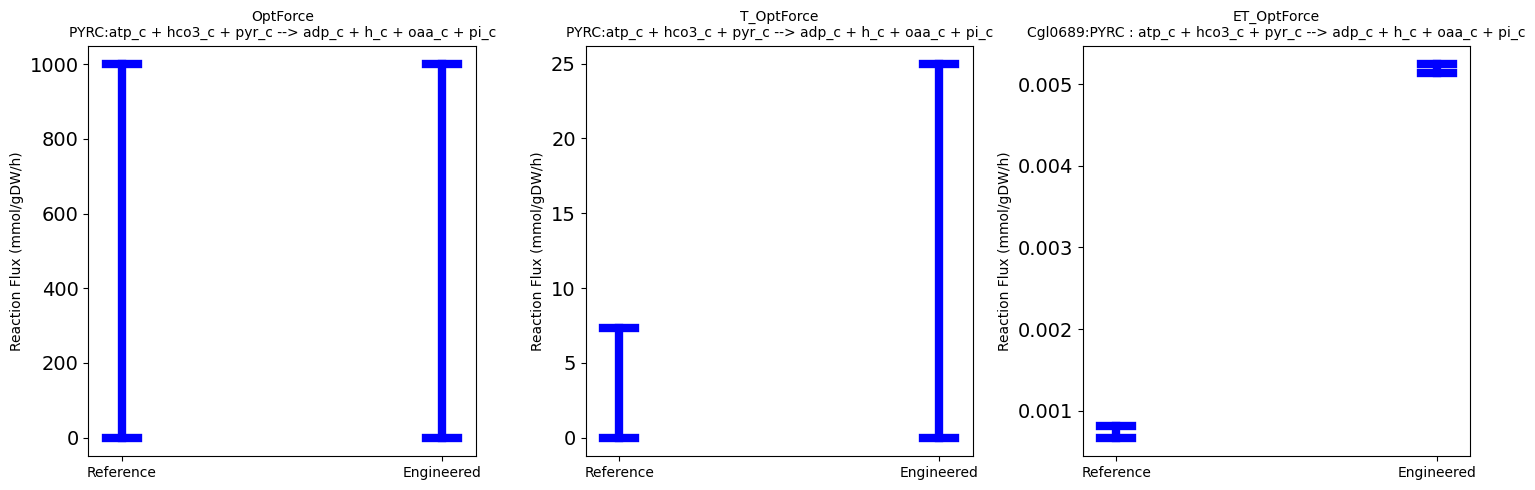

In [ ]:
# L_Lysine
import matplotlib.pyplot as plt
import os

# Data for three plots
data = [
    s_temp_dict_pyrc,
    T_result_dict_pyrc,
    et_temp_dict_pyrc

]
# Save path


# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, item in zip(axes, data):
    id = item['id']
    reaction = item['reaction']
    ranges = {'Reference': item['wild_range'], 'Engineered': item['eng_range']}

    for i, (name, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)  # Convert to float
        width = end - start
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()))
    ax.tick_params(axis='y', labelsize=14)

    if i < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)')
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)')
    
    ax.set_xlabel('')
    # ax.set_ylabel('enzyme cost g/gDW')
    # ax.set_xlabel('')
    ax.set_title(id + "\n" + reaction)
    ax.grid(False)
    
    # Set title with different font sizes
    if i == 0:
        ax.set_title(id + "\n" + reaction, fontsize=12)
    else:
        ax.set_title(id + "\n" + reaction, fontsize=10)

plt.tight_layout()

# Save and show the combined plot
plt.savefig(os.path.join(savepath, 'optforce_pyrc.svg'))
plt.show()


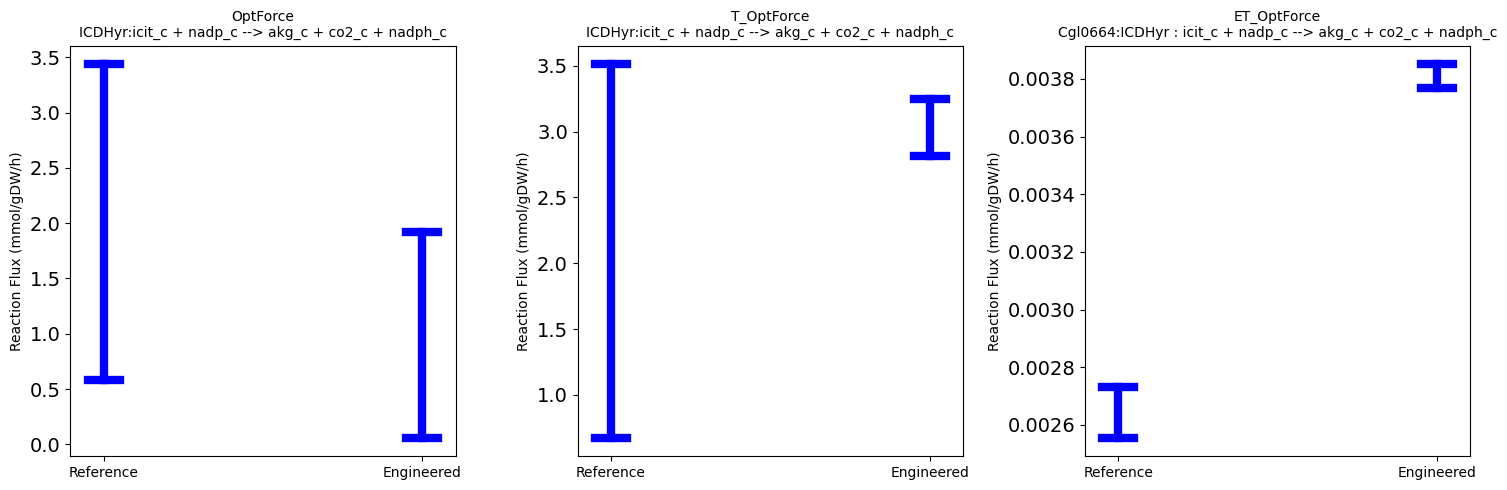

In [ ]:
# Data for three plots
data = [
    s_temp_dict_icd,
    T_result_dict_icd,
    et_temp_dict_icd

]


# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, item in zip(axes, data):
    id = item['id']
    reaction = item['reaction']
    ranges = {'Reference': item['wild_range'], 'Engineered': item['eng_range']}

    for i, (name, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)  # Convert to float
        width = end - start
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()))
    ax.tick_params(axis='y', labelsize=14)

    if i < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)')
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)')
    
    ax.set_xlabel('')
    # ax.set_ylabel('enzyme cost g/gDW')
    # ax.set_xlabel('')
    ax.set_title(id + "\n" + reaction)
    ax.grid(False)
    
    # Set title with different font sizes
    if i == 0:
        ax.set_title(id + "\n" + reaction, fontsize=12)
    else:
        ax.set_title(id + "\n" + reaction, fontsize=10)

plt.tight_layout()

# Save and show the combined plot
plt.savefig(os.path.join(savepath, 'optforce_icdhyr.svg'))
plt.show()


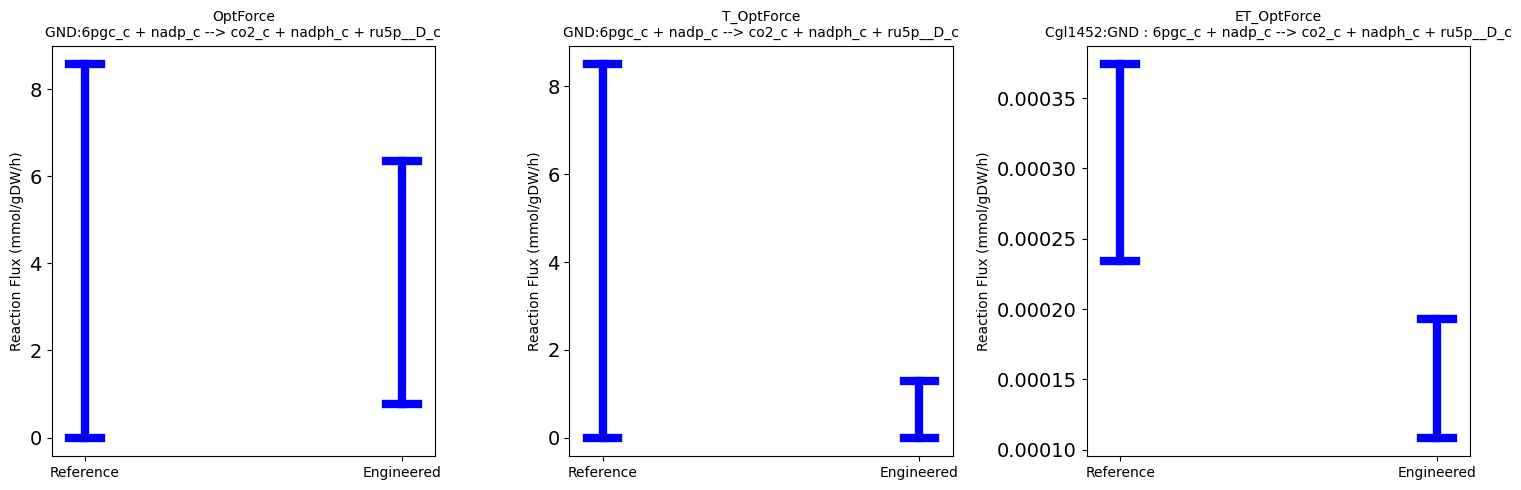

In [ ]:
# Data for three plots
data = [
    s_temp_dict_gnd,
    T_result_dict_gnd,
    et_temp_dict_gnd

]


# Create a figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, item in zip(axes, data):
    id = item['id']
    reaction = item['reaction']
    ranges = {'Reference': item['wild_range'], 'Engineered': item['eng_range']}

    for i, (name, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)  # Convert to float
        width = end - start
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i-0.05, i+0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()))
    ax.tick_params(axis='y', labelsize=14)

    if i < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)')
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)')
    
    ax.set_xlabel('')
    # ax.set_ylabel('enzyme cost g/gDW')
    # ax.set_xlabel('')
    ax.set_title(id + "\n" + reaction)
    ax.grid(False)
    
    # Set title with different font sizes
    if i == 0:
        ax.set_title(id + "\n" + reaction, fontsize=12)
    else:
        ax.set_title(id + "\n" + reaction, fontsize=10)

plt.tight_layout()

# Save and show the combined plot
plt.savefig(os.path.join(savepath, 'optforce_gnd.svg'))
plt.show()
